In [377]:
import pandas as pd
import numpy as np
import math
import lifelines
import scipy

import matplotlib.pyplot as plt

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

from causallib.estimation import IPW

In [103]:
UNOS_data = pd.read_csv("data/UNOS_train.csv")

In [104]:
patient_variables   = ["init_age", "gender", "hgt_cm_tcr", "wgt_kg_tcr", "diab", "ventilator_tcr",
                       "ecmo_tcr", "most_rcnt_creat", "abo_A", "abo_B", "abo_O", "vad_while_listed",
                       "iabp_tcr",
                       "init_bmi_calc", "tah", "inotropic", "Censor (Censor = 1)", "Survival Time"]

# removed: "days_stat1", "days_stat1a", "days_stat2", "days_stat1b",

In [105]:
# cleaning up dataframe
UNOS_data = UNOS_data[patient_variables]

UNOS_data = UNOS_data[UNOS_data['Survival Time']>=0]

# Part 1: Hypothesis Testing & Confounding 

## Task 1.1

In [106]:
def statistics_at_j(df, time, column_of_interest = 'vad_while_listed' ):
    # Get all the patients at risk at that time
    at_risk_at_j = df[df['Survival Time']>=time]
    nt_j = len(at_risk_at_j)
    nt_j_1 = len(at_risk_at_j[at_risk_at_j[column_of_interest]==1])
    nt_j_0 = len(at_risk_at_j[at_risk_at_j[column_of_interest]==0])

    # Get all the events at that time
    events_at_j = df[(df['Survival Time']==time) & (df['Censor (Censor = 1)']==0)]
    dt_j = len(events_at_j)
    dt_j_1 = len(events_at_j[events_at_j[column_of_interest]==1])

    e_j = (nt_j_1/nt_j) * dt_j
    v_j = (nt_j_0 * nt_j_1 * dt_j * (nt_j - dt_j))/(nt_j*nt_j*(nt_j-1))

    return e_j, v_j, dt_j_1

def log_rank_statistic(df, column_of_interest = 'vad_while_listed'):
    times = np.sort(df[df['Censor (Censor = 1)']==0]['Survival Time'].unique())
    numerator = 0 
    sq_denominator = 0
    for time in times:
        e_j, v_j, dt_j_1 = statistics_at_j(df, time, column_of_interest)
        numerator += (dt_j_1 - e_j)
        sq_denominator += v_j

    log_rank_statistic = numerator/ math.sqrt(sq_denominator)  

    return log_rank_statistic 


In [107]:
statistic = log_rank_statistic(UNOS_data)
print(statistic)

7.642021036449715


In [108]:
p_value = 2* (1-scipy.stats.norm.cdf(statistic))

print(p_value)

2.1316282072803006e-14


In [109]:
# Sanity check
durations_A = UNOS_data[UNOS_data['vad_while_listed'] == 0]['Survival Time']
durations_B = UNOS_data[UNOS_data['vad_while_listed'] == 1]['Survival Time']
event_observed_A = 1-UNOS_data[UNOS_data['vad_while_listed'] == 0]['Censor (Censor = 1)']
event_observed_B = 1-UNOS_data[UNOS_data['vad_while_listed'] == 1]['Censor (Censor = 1)']

results  = logrank_test(durations_A, durations_B, event_observed_A, event_observed_B )

# They report chi-squared which is the square of the statistic we computed
print(math.sqrt(results.test_statistic))

7.642021036450056


In [110]:
results.summary

,test_statistic,p,-log2(p)
0,58.400486,2.138382e-14,45.410474


## Task 1.2

In [111]:
UNOS_data.columns

Index(['init_age', 'gender', 'hgt_cm_tcr', 'wgt_kg_tcr', 'diab',
       'ventilator_tcr', 'ecmo_tcr', 'most_rcnt_creat', 'abo_A', 'abo_B',
       'abo_O', 'vad_while_listed', 'iabp_tcr', 'init_bmi_calc', 'tah',
       'inotropic', 'Censor (Censor = 1)', 'Survival Time'],
      dtype='object')

In [112]:
def evaluate_predictive_power(X, y):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    accuracy = accuracy_score(y, y_pred)
    #print(f"Accuracy: {accuracy}")
    auc = roc_auc_score(y, y_prob)
    return auc

In [113]:
features = [col for col in UNOS_data.columns if col not in ['Censor (Censor = 1)', 'Survival Time', "vad_while_listed"]]
# First, find variables predictive of VAD

X, y, y_surv = UNOS_data[features], UNOS_data["vad_while_listed"], UNOS_data['Survival Time']

auc_vads = []
#auc_survivals = []
for col in X.columns:
    auc_vad = evaluate_predictive_power(X[[col]], y)
    #auc_survival = evaluate_predictive_power(X[[col]], y_surv)
    auc_vads.append(auc_vad)
    #auc_survivals.append(auc_survival)

results = pd.DataFrame({
    'columns': features,
    'AUC VAD': auc_vads,
    #'AUC Survival': auc_survivals
})

In [114]:
results

,columns,AUC VAD
0,init_age,0.587812
1,gender,0.528427
2,hgt_cm_tcr,0.528441
3,wgt_kg_tcr,0.586230
4,diab,0.542565
5,ventilator_tcr,0.502679
6,ecmo_tcr,0.507585
7,most_rcnt_creat,0.588479
8,abo_A,0.520832
9,abo_B,0.509263


In [115]:
# Step 1: Cox model WITHOUT adjustment

UNOS_data['death_event'] = 1- UNOS_data['Censor (Censor = 1)']

cph1 = CoxPHFitter()
cph1.fit(UNOS_data[['Survival Time', 'death_event', 'vad_while_listed']], 
         duration_col='Survival Time', event_col='death_event')
hr_unadjusted = cph1.summary.loc['vad_while_listed', 'exp(coef)']

# Step 2: Cox model WITH confounders
hr_adjusted_list = []
#auc_survivals = []
for col in X.columns:
    confounders = [col]
    cph2 = CoxPHFitter()
    cph2.fit(UNOS_data[['Survival Time', 'death_event', 'vad_while_listed']+ confounders], 
         duration_col='Survival Time', event_col='death_event')
    hr_adjusted = cph2.summary.loc['vad_while_listed', 'exp(coef)']
    hr_adjusted_list.append(hr_adjusted)
    # print("HR without adjustment:", hr_unadjusted)
    # print("HR with confounder adjustment:", hr_adjusted)


results = pd.DataFrame({
    'columns': features,
    'hr_adjusted': hr_adjusted_list,
    'difference': hr_adjusted_list - hr_unadjusted
    #'AUC Survival': auc_survivals
})


In [116]:
results

,columns,hr_adjusted,difference
0,init_age,1.374743,-0.031559
1,gender,1.426067,0.019765
2,hgt_cm_tcr,1.400941,-0.005361
3,wgt_kg_tcr,1.427994,0.021692
4,diab,1.392406,-0.013896
5,ventilator_tcr,1.394122,-0.012180
6,ecmo_tcr,1.412635,0.006333
7,most_rcnt_creat,1.410334,0.004032
8,abo_A,1.414222,0.007920
9,abo_B,1.406990,0.000688


## Task 1.3

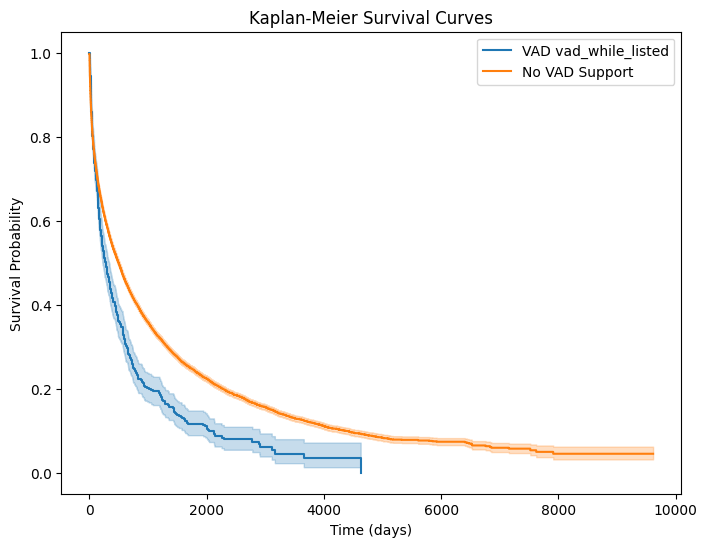

In [117]:
# Step 0: Fit Kaplan-Meier as-is
kmf_vad = KaplanMeierFitter()
kmf_no_vad = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

# Fit and plot for VAD group
kmf_vad.fit(UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'Survival Time'], 
            UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'death_event'])
kmf_vad.plot_survival_function(label="VAD vad_while_listed", ci_show=True)

# Fit and plot for No-VAD group
kmf_no_vad.fit(UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'Survival Time'], 
               UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'death_event'])
kmf_no_vad.plot_survival_function(label="No VAD Support", ci_show=True)

plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

/opt/anaconda3/envs/project1/lib/python3.11/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/opt/anaconda3/envs/project1/lib/python3.11/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation w

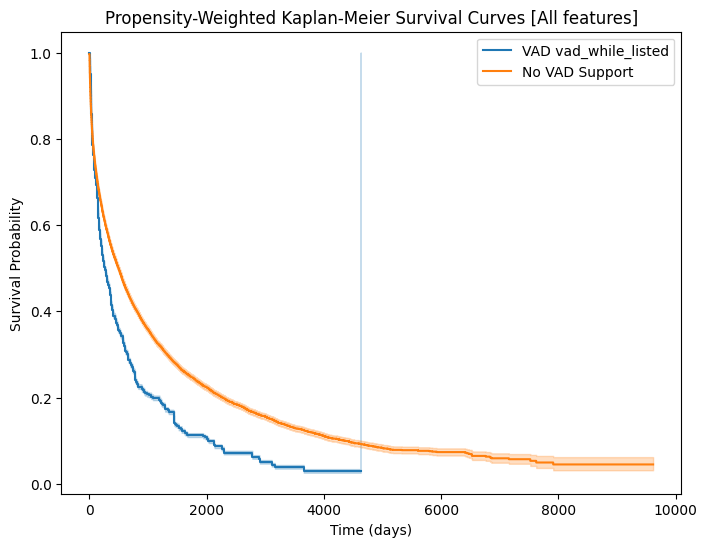

In [137]:
confounders = features

# Step 1: Estimate Propensity Score
logit = LogisticRegression(max_iter=3000)
logit.fit(UNOS_data[confounders], UNOS_data['vad_while_listed'])
UNOS_data['propensity_score'] = logit.predict_proba(UNOS_data[confounders])[:, 1]

# Step 2: Compute Inverse Probability Weights (IPW)
UNOS_data['ipw'] = np.where(UNOS_data['vad_while_listed'] == 1, 
                     1 / UNOS_data['propensity_score'], 
                     1 / (1 - UNOS_data['propensity_score']))

# Step 3: Fit Kaplan-Meier with Weights
kmf_vad = KaplanMeierFitter()
kmf_no_vad = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

# Fit and plot for VAD group
kmf_vad.fit(UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'Survival Time'], 
            UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'death_event'], 
            weights=UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'ipw'])
kmf_vad.plot_survival_function(label="VAD vad_while_listed", ci_show=True)

# Fit and plot for No-VAD group
kmf_no_vad.fit(UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'Survival Time'], 
               UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'death_event'], 
               weights=UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'ipw'])
kmf_no_vad.plot_survival_function(label="No VAD Support", ci_show=True)

plt.title("Propensity-Weighted Kaplan-Meier Survival Curves [All features]")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

/opt/anaconda3/envs/project1/lib/python3.11/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/opt/anaconda3/envs/project1/lib/python3.11/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation w

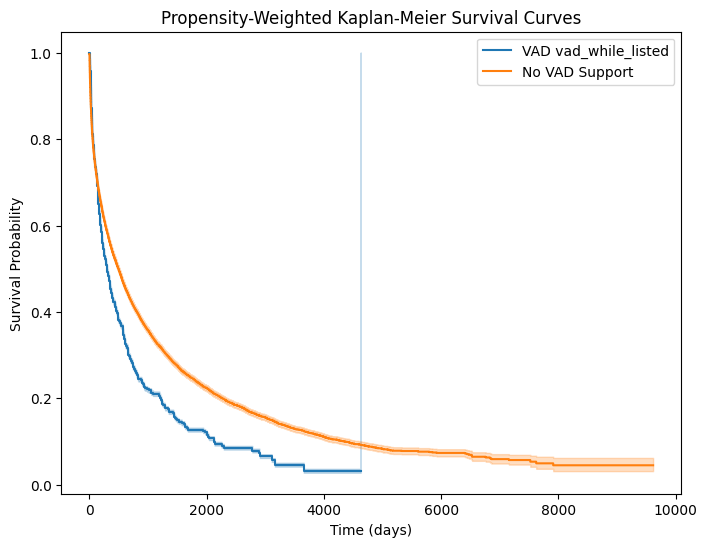

In [138]:
confounders = ['iabp_tcr']

# Step 1: Estimate Propensity Score
logit = LogisticRegression(max_iter=3000)
logit.fit(UNOS_data[confounders], UNOS_data['vad_while_listed'])
UNOS_data['propensity_score'] = logit.predict_proba(UNOS_data[confounders])[:, 1]

# Step 2: Compute Inverse Probability Weights (IPW)
UNOS_data['ipw'] = np.where(UNOS_data['vad_while_listed'] == 1, 
                     1 / UNOS_data['propensity_score'], 
                     1 / (1 - UNOS_data['propensity_score']))

# Step 3: Fit Kaplan-Meier with Weights
kmf_vad = KaplanMeierFitter()
kmf_no_vad = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

# Fit and plot for VAD group
kmf_vad.fit(UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'Survival Time'], 
            UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'death_event'], 
            weights=UNOS_data.loc[UNOS_data['vad_while_listed'] == 1, 'ipw'])
kmf_vad.plot_survival_function(label="VAD vad_while_listed", ci_show=True)

# Fit and plot for No-VAD group
kmf_no_vad.fit(UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'Survival Time'], 
               UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'death_event'], 
               weights=UNOS_data.loc[UNOS_data['vad_while_listed'] == 0, 'ipw'])
kmf_no_vad.plot_survival_function(label="No VAD Support", ci_show=True)

plt.title("Propensity-Weighted Kaplan-Meier Survival Curves")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

## Task 1.4

In [139]:
def statistics_at_j_weighted(df, time, column_of_interest='vad_while_listed'):
    # Patients at risk at time j
    at_risk_at_j = df[df['Survival Time'] >= time]
    nt_j = at_risk_at_j['ipw'].sum()  # Weighted count of at-risk patients
    nt_j_1 = at_risk_at_j.loc[at_risk_at_j[column_of_interest] == 1, 'ipw'].sum()
    nt_j_0 = at_risk_at_j.loc[at_risk_at_j[column_of_interest] == 0, 'ipw'].sum()

    # Patients with events at time j
    events_at_j = df[(df['Survival Time'] == time) & (df['Censor (Censor = 1)'] == 0)]
    dt_j = events_at_j['ipw'].sum()  # Weighted count of events
    dt_j_1 = events_at_j.loc[events_at_j[column_of_interest] == 1, 'ipw'].sum()

    # Compute expected events and variance using weights
    e_j = (nt_j_1 / nt_j) * dt_j if nt_j > 0 else 0
    v_j = (nt_j_0 * nt_j_1 * dt_j * (nt_j - dt_j)) / (nt_j**2 * (nt_j - 1)) if nt_j > 1 else 0

    return e_j, v_j, dt_j_1

def log_rank_statistic_weighted(df, column_of_interest='vad_while_listed'):
    """Compute the IPTW-adjusted Log-Rank test statistic."""
    times = np.sort(df[df['Censor (Censor = 1)'] == 0]['Survival Time'].unique())
    numerator = 0 
    sq_denominator = 0

    for time in times:
        e_j, v_j, dt_j_1 = statistics_at_j_weighted(df, time, column_of_interest)
        numerator += (dt_j_1 - e_j)
        sq_denominator += v_j

    log_rank_statistic = numerator / math.sqrt(sq_denominator) if sq_denominator > 0 else 0
    return log_rank_statistic  

In [140]:
statistic = log_rank_statistic_weighted(UNOS_data)
print(statistic)

28.79855301555256


In [141]:
p_value = 2* (1-scipy.stats.norm.cdf(statistic))

print(p_value)

0.0


# Part 2

In [200]:
ist_df = pd.read_csv("/Users/natalia/Documents/CPH200b/cph-200b-project1/project2/data/IST/IST_observational.csv")

In [201]:
ist_df

,Unnamed: 0,HOSPNUM,RDELAY,RCONSC,SEX,AGE,RSLEEP,RATRIAL,RCT,RVISINF,...,H14,ISC14,NK14,STRK14,HTI14,PE14,DVT14,TRAN14,NCB14,include
0,4,4,20,F,M,78,N,NaN,N,N,...,0,0,0,0,0,0,0,0,0,1
1,7,1,24,F,M,23,N,NaN,Y,N,...,0,0,0,0,0,0,0,0,0,1
2,13,1,12,F,F,86,Y,NaN,Y,N,...,0,0,0,0,0,0,0,0,0,1
3,19,6,4,F,M,74,N,NaN,N,N,...,0,0,0,0,0,0,0,0,0,1
4,24,1,17,F,M,57,N,NaN,N,N,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4759,19407,242,6,F,F,85,N,N,Y,N,...,0,0,0,0,0,0,0,0,0,1
4760,19411,5,6,D,M,71,N,N,Y,N,...,1,0,0,1,0,0,0,0,0,1
4761,19417,144,45,F,M,71,N,N,Y,N,...,0,0,0,0,0,0,0,0,0,1
4762,19419,38,4,F,F,81,N,N,N,N,...,0,0,0,0,0,0,0,0,0,1


## Part 2.1

In [ ]:
# variable for death 14 days = ID14
# variable for aspirin randomization = RXASP
# variable for heparin randomization = RXHEP (N is no, others are different doses)

In [202]:
ist_df['ID14'].value_counts()

ID14
0    4221
1     543
Name: count, dtype: int64

In [169]:
def difference_in_means(df, column):
    treated = df[df[column]!='N']
    mean_treated = len(treated[treated['ID14']==1])/len(treated)
    print(mean_treated)
    non_treated = df[df[column]=='N']

    mean_non_treated= len(non_treated[non_treated['ID14']==1])/len(non_treated)
    print(mean_non_treated)
    return mean_non_treated-mean_treated

In [203]:
difference_in_means(ist_df, 'RXASP')

0.09126984126984126
0.12453874538745388


0.033268904117612616

In [204]:
difference_in_means(ist_df, 'RXHEP')

0.11036508602601762
0.11759764804703907


0.007232562021021446

In [205]:
column = 'RXHEP'

non_treated = ist_df[ist_df[column]=='N']
mean_non_treated= len(non_treated[non_treated['ID14']==1])/len(non_treated)
print(mean_non_treated)

treated = ist_df[ist_df[column] == 'L']
mean_treated = len(treated[treated['ID14']==1])/len(treated)
print(mean_treated)
print(mean_non_treated-mean_treated)

treated = ist_df[ist_df[column].isin(['H', 'M'])]
mean_treated = len(treated[treated['ID14']==1])/len(treated)
print(mean_treated)
print(mean_non_treated-mean_treated)


0.11759764804703907
0.09422750424448217
0.023370143802556892
0.12614107883817427
-0.008543430791135204


## Part 2.2

In [382]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder


In [209]:

def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    label_encoders = {}
    for column in df.columns:
        if df[column].dtype == 'object':  # Check if the column contains strings
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column].astype(str))  # Convert to string then encode
            label_encoders[column] = le  # Store encoder in case inverse transform is needed
    
    return df

In [300]:
features = ['HOSPNUM', 'RDELAY','RCONSC','SEX','AGE','RSLEEP', 'RATRIAL', 'RCT','RVISINF', 'RHEP24', 
            'RASP3','RSBP','RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 
            'RDEF6', 'RDEF7', 'RDEF8', 'STYPE']

df = ist_df.copy()
df['RXHEP_binarized'] = np.where(df['RXHEP']=='N', 'N', 'Y')

df['RXASP_int'] = np.where(df['RXASP']=='Y', 1, 0)
df['RXHEP_binarized_int'] = np.where(df['RXHEP_binarized']=='Y', 1, 0)
df[features] = preprocess_dataframe(df[features])



/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_1457/869983922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))  # Convert to string then encode
/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_1457/869983922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))  # Convert to string then encode
/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_1457/869983922.py:6: Settin

In [369]:
def compute_ipw_weights(df, features, column):
    # Step 1: Estimate Propensity Score
    df = df.copy()
    prop_model = GradientBoostingClassifier()
    prop_model.fit(df[features], df[column])
    propensity_score_col = f'propensity_score_{column}'
    df[propensity_score_col] = prop_model.predict_proba(df[features])[:, 1]

    # Step 2: Compute Inverse Probability Weights (IPW)
    ipw_column = f'ipw_{column}'
    df[ipw_column] = np.where(df[column] == 'Y', 
                        1 / df[propensity_score_col], 
                        1 / (1 - df[propensity_score_col]))

    return df


def ipw_estimator(df, column, ipw_column):
    treated = df[df[column]!='N']
    mean_treated =  np.average(treated['ID14'], weights=treated[ipw_column])
    print(mean_treated)

    non_treated = df[df[column]=='N']
    mean_non_treated= np.average(non_treated['ID14'], weights=non_treated[ipw_column])
    print(mean_non_treated)

    return mean_non_treated-mean_treated

In [370]:
column = 'RXASP'
df = compute_ipw_weights(df,features, column)

ipw_estimator(df, column, 'ipw_RXASP')

0.1127433200322076
0.11529202725989429


np.float64(0.0025487072276866862)

In [376]:
# as a sanity check

learner = GradientBoostingClassifier()
ipw = IPW(learner)
ipw.fit(df[features], df['RXASP'])
outcomes = ipw.estimate_population_outcome(df[features], df['RXASP'], df['ID14'])
outcomes

N    0.115292
Y    0.112743
dtype: float64

In [371]:
column = 'RXHEP_binarized'
df = compute_ipw_weights(df,features, column)

ipw_estimator(df, 'RXHEP_binarized', 'ipw_RXHEP_binarized')

0.11102245976742854
0.11615103735260149


np.float64(0.005128577585172947)

In [378]:
# as a sanity check

learner = GradientBoostingClassifier()
ipw = IPW(learner)
ipw.fit(df[features], df['RXHEP_binarized'])
outcomes = ipw.estimate_population_outcome(df[features], df['RXHEP_binarized'], df['ID14'])
outcomes

N    0.116151
Y    0.111022
dtype: float64

## Part 2.3

In [484]:

def train_t_learner(df, features, column, no_treatment = 'N'):
    # Split data into treatment and control groups
    X = df[features]
    treated = df[df[column]!=no_treatment]
    X_treat, y_treat = treated[features], treated['ID14']

    non_treated = df[df[column]==no_treatment]
    X_control, y_control = non_treated[features], non_treated['ID14']

    # Train separate models for each group
    model_treat = GradientBoostingClassifier()
    model_treat.fit(X_treat, y_treat)
    model_control = GradientBoostingClassifier()
    model_control.fit(X_control, y_control)

    # Predict treatment effect: difference in predicted outcomes
    tau_hat = model_control.predict(X) - model_treat.predict(X)
    tau_hat_mean = tau_hat.mean()

    return tau_hat_mean, tau_hat, model_treat, model_control

In [485]:
column = 'RXASP'

train_t_learner(df, features, column)

(np.float64(-0.018891687657430732),
 array([0, 0, 0, ..., 0, 0, 0]),
 GradientBoostingClassifier(),
 GradientBoostingClassifier())

In [486]:
column = 'RXHEP_binarized'

train_t_learner(df, features, column)

(np.float64(-0.0031486146095717885),
 array([0, 0, 0, ..., 0, 0, 0]),
 GradientBoostingClassifier(),
 GradientBoostingClassifier())

In [418]:
def train_s_learner(df, features, column):
    # Split data into treatment and control groups
    X = df[features+[column]]
    y_treat = df['ID14']

    # Train separate models for each group
    model = GradientBoostingClassifier().fit(X, y_treat)

    X_pseudo_non_treat = X.copy()
    X_pseudo_treat = X.copy()
    X_pseudo_non_treat[column] = 0
    X_pseudo_treat[column] = 1

    # Predict treatment effect: difference in predicted outcomes
    tau_hat_mean =  model.predict(X_pseudo_non_treat).mean() - model.predict(X_pseudo_treat).mean()

    return tau_hat_mean

In [419]:
column = 'RXASP_int'

train_s_learner(df, features, column)

np.float64(0.004408060453400503)

In [420]:
column = 'RXHEP_binarized_int'

train_s_learner(df, features, column)

np.float64(0.0002099076406381177)

In [532]:
def train_x_learner(df, features, column, no_treatment = 'N'):
    X, treatment = df[features], df[column]
    treated = df[df[column]!=no_treatment]
    X_treat, y_treat = treated[features], treated['ID14']
    non_treated = df[df[column]==no_treatment]
    X_control, y_control = non_treated[features], non_treated['ID14']

    # Step 1: Train T-Learner models
    tau_hat_t_mean, tau_hat_t, model_treat, model_control = train_t_learner(df, features, column, no_treatment)
    
    # Step 2: Compute residuals
    d_treat = y_treat - model_control.predict(X_treat)
    d_control = model_treat.predict(X_control) - y_control

    # Step 3: Train models to predict treatment effects
    model_tau_treat = GradientBoostingRegressor().fit(X_treat, d_treat)
    model_tau_control = GradientBoostingRegressor().fit(X_control, d_control)

    # Step 4: Predict treatment effects for all patients
    tau_hat_treat = model_tau_treat.predict(X)
    tau_hat_control = model_tau_control.predict(X)

    # Combine estimates (weighted average)
    prop_scores = compute_ipw_weights(df,features, column)[f'propensity_score_{column}']
    tau_hat = (prop_scores) * tau_hat_control + (1 - prop_scores) * tau_hat_treat

    return tau_hat.mean()

In [533]:
column = 'RXASP'

train_x_learner(df, features, column, no_treatment='N')

np.float64(0.04802876714705703)

In [534]:
#not sure why this does not match!

from causallib.estimation import Standardization, StratifiedStandardization, XLearner

column = 'RXASP_int'
xlearner = XLearner(
    outcome_model=StratifiedStandardization(GradientBoostingClassifier()),
    effect_model=StratifiedStandardization(GradientBoostingRegressor()),
    effect_types="diff",
)
_ = xlearner.fit(df[features], df[column], df['ID14'])
effect = xlearner.estimate_effect(df[features], df[column])  #

effect

diff    0.000737
dtype: float64

In [535]:
column = 'RXHEP_binarized'

train_x_learner(df, features, column)

np.float64(-0.0019514886539288279)

In [536]:
from causallib.estimation import Standardization, StratifiedStandardization, XLearner

column = 'RXHEP_binarized_int'
xlearner = XLearner(
    outcome_model=StratifiedStandardization(GradientBoostingClassifier()),
    effect_model=StratifiedStandardization(GradientBoostingRegressor()),
    effect_types="diff",
)
_ = xlearner.fit(df[features], df[column], df['ID14'])
effect = xlearner.estimate_effect(df[features], df[column])  #

effect

diff   -0.007134
dtype: float64

## Part 2.4

In [456]:
def augmented_ipw(df, features, column):
    df = compute_ipw_weights(df, features, column)

    outcome_model = GradientBoostingClassifier()
    outcome_model.fit(df[features + [column]], df['ID14'])

    # Predict counterfactual outcomes
    X_treated = df[features].copy()
    X_treated[column] = 1 
    df['mu1'] = outcome_model.predict(X_treated)  # E[Y | X, T=1]

    X_untreated = df[features].copy()
    X_untreated[column] = 0  # Set treatment indicator to 0
    df['mu0'] = outcome_model.predict(X_untreated)  # E[Y | X, T=0]

    # Step 3: Compute AIPW estimate
    treated = df[column] == 1
    untreated = ~treated

    # Compute doubly robust estimator
    y = df['ID14']
    aipw_treated = (treated * (y - df['mu1']) / df[f'propensity_score_{column}']) + df['mu1']
    aipw_untreated = (untreated * (y - df['mu0']) / (1 - df[f'propensity_score_{column}'])) + df['mu0']

    # Compute AIPW treatment effect estimate
    aipw_estimate = np.mean(aipw_treated - aipw_untreated)

    return aipw_estimate

In [457]:
column = 'RXASP_int'

augmented_ipw(df, features, column)

np.float64(-0.006158955639216543)

In [465]:
#sanity check

from causallib.estimation import AIPW
column = 'RXASP_int'

ipw = IPW(GradientBoostingClassifier())
std = Standardization(GradientBoostingClassifier())

dr = AIPW(std, ipw)
dr.fit(df[features], df[column], df['ID14'])
pop_outcome = dr.estimate_population_outcome(df[features], df[column], df['ID14'])
pop_outcome[1]-pop_outcome[0]

/opt/anaconda3/envs/project1/lib/python3.11/site-packages/causallib/estimation/doubly_robust.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  individual_cf.loc[a == treatment_value, treatment_value] = corrected_outcome.loc[a == treatment_value]
/opt/anaconda3/envs/project1/lib/python3.11/site-packages/causallib/estimation/doubly_robust.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.         0.         1.46675718 ... 0.         0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  individual_cf.loc[a == treatment_value, treatment_value] = corrected_outcome.loc[a == treatment_value]


np.float64(-0.00636886327985467)

In [458]:
column = 'RXHEP_binarized_int'

augmented_ipw(df, features, column)

np.float64(-0.009281267914382963)

In [464]:
#sanity check

from causallib.estimation import AIPW
column = 'RXHEP_binarized_int'

ipw = IPW(GradientBoostingClassifier())
std = Standardization(GradientBoostingClassifier())

dr = AIPW(std, ipw)
dr.fit(df[features], df[column], df['ID14'])
pop_outcome = dr.estimate_population_outcome(df[features], df[column], df['ID14'])
pop_outcome[1]-pop_outcome[0]

/opt/anaconda3/envs/project1/lib/python3.11/site-packages/causallib/estimation/doubly_robust.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.        1.9397842 0.        ... 0.        0.        0.       ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  individual_cf.loc[a == treatment_value, treatment_value] = corrected_outcome.loc[a == treatment_value]
/opt/anaconda3/envs/project1/lib/python3.11/site-packages/causallib/estimation/doubly_robust.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.        0.        0.        ... 0.        1.9112378 0.       ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  individual_cf.loc[a == treatment_value, treatment_value] = corrected_outcome.loc[a == treatment_value]


np.float64(-0.00907136027374486)

# Part 3

In [806]:
ihdp_df = pd.read_csv('/Users/natalia/Documents/CPH200b/cph-200b-project1/project2/data/ihdp_project2.csv')

In [854]:
ihdp_df

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X24,X25,T,Y,Y_cf,Y1,Y0,ITE,ps,CATE
0,0,0.316588,0.596582,-0.360898,-0.879606,0.371086,-1.189018,1.0,0.0,1.0,...,0.0,0.0,1,6.221720,6.221720,6.221720,1.938568,4.283151,0.096134,4.651689
1,1,0.186891,0.196818,-0.360898,0.161703,-1.379396,0.467138,0.0,0.0,1.0,...,0.0,1.0,0,3.899687,5.741144,5.741144,3.899687,1.841458,0.346382,4.029681
2,2,0.532750,0.196818,-0.360898,-0.879606,1.934016,-1.354634,0.0,0.0,0.0,...,0.0,0.0,0,2.405894,6.709281,6.709281,2.405894,4.303386,0.071968,4.644078
3,3,0.294972,-0.202946,-0.360898,-0.879606,0.121017,-1.023402,0.0,0.0,1.0,...,0.0,1.0,0,1.469327,6.868562,6.868562,1.469327,5.399234,0.294487,4.635409
4,4,-0.548057,-0.202946,-0.360898,-0.879606,0.183534,-0.360940,0.0,1.0,0.0,...,0.0,0.0,0,0.558776,6.471721,6.471721,0.558776,5.912945,0.138918,4.509761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,70,1.116385,0.596582,-0.360898,1.203011,0.683672,0.135907,0.0,0.0,0.0,...,0.0,0.0,1,6.320008,6.320008,6.320008,2.573101,3.746907,0.099506,4.073843
743,71,0.489517,0.596582,-0.733261,0.161703,1.058775,0.467138,0.0,0.0,1.0,...,0.0,1.0,1,4.974808,1.495454,4.974808,1.495454,3.479354,0.204716,4.176489
744,72,1.159618,0.996346,0.011465,-0.879606,-0.129052,-0.360940,1.0,0.0,1.0,...,0.0,0.0,1,8.094804,8.094804,8.094804,1.235665,6.859139,0.336337,4.509761
745,73,-2.298964,-1.402238,1.500917,-0.879606,-2.942326,1.460832,1.0,0.0,1.0,...,0.0,0.0,0,2.632686,7.226212,7.226212,2.632686,4.593526,0.099023,3.669816


## Part 3.1

In [807]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [1130]:

def mmd_rbf(Xt, Xc, p, sig=0.1):
    sig = torch.tensor(sig)
    Kcc = torch.exp(-torch.cdist(Xc, Xc, 2.0001) / torch.sqrt(sig))
    Kct = torch.exp(-torch.cdist(Xc, Xt, 2.0001) / torch.sqrt(sig))
    Ktt = torch.exp(-torch.cdist(Xt, Xt, 2.0001) / torch.sqrt(sig))

    m = Xc.shape[0]
    n = Xt.shape[0]

    mmd = (1 - p) ** 2 / (m *(m-1)) * (Kcc.sum() - m)
    mmd += p ** 2 / (n * (n-1)) * (Ktt.sum() - n)
    mmd -= 2 * p * (1 - p) / (m * n) * Kct.sum()
    mmd *= 4

    return mmd

def mse_loss_function(predictions, targets):
    loss = nn.MSELoss()
    return loss(predictions, targets)

def l2_regularization_hypothesis(model):
    l2_reg = 0
    for param in model.control_model.parameters():
        l2_reg += torch.norm(param, 2)
    for param in model.treatment_model.parameters():
        l2_reg += torch.norm(param, 2)
    return l2_reg

def mmd_lin(Xt, Xc):
    mean_treated = Xt.mean(dim=0)
    mean_control = Xc.mean(dim=0)

    mmd = 2.0 * torch.norm(mean_treated - mean_control, p=2)
    return mmd


def total_loss(representations, predictions, treatment, outcomes, lambda_, alpha_):
    # MSE loss
    mse_loss = mse_loss_function(predictions, outcomes)

    # Regularization loss
    l2_reg = l2_regularization_hypothesis(model)
    
    # IPMG loss
    ipmg_term = mmd_lin(representations[treatment==1], representations[treatment==0])

    # Total loss
    total_loss =  mse_loss + lambda_ * l2_reg + alpha_ * ipmg_term
    return total_loss, mse_loss, l2_reg, ipmg_term


In [1131]:

class TARNet(nn.Module):
    def __init__(self, backbone, control_model, treatment_model):
        super(TARNet, self).__init__()
        self.backbone = backbone
        self.control_model = control_model
        self.treatment_model = treatment_model

    def forward(self, inputs):
        x, t = inputs
        t = t.unsqueeze(1)

        # Step 1
        representations = self.backbone(x)

        # Step 2
        control = self.control_model(representations)
        treatment = self.treatment_model(representations)

        # Step 3
        selected_output = control * (1 - t) + treatment * t

        return representations, selected_output.squeeze(1)
    

def normalize_data(data, features):
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    return data, scaler


In [1150]:
def train_model(df_train, input_columns, model, optimizer, n_epochs, lambda_, alpha_):
    model.train()
    df_train = df_train.copy()

    training_data, scaler = normalize_data(df_train.copy(), input_columns)
    treatment = torch.tensor(df_train['T'].values, dtype=torch.float32)
    outcomes = torch.tensor(df_train['Y'].values, dtype=torch.float32)
    features = torch.tensor(training_data[input_columns].values, dtype=torch.float32)

    # Training loop
    for epoch in range(n_epochs):
        optimizer.zero_grad()

        representations, y_pred = model((features, treatment))

        loss, mse_loss, l2_reg, ipmg_term = total_loss(representations, y_pred, treatment, outcomes, lambda_, alpha_)
        loss.backward()    
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, MSE_loss: {mse_loss.item():.4f}, L2 reg: {l2_reg.item():.4f}, IPMG reg: {ipmg_term.item():.4f}")
    
    # finish training
    model.eval()
    return model, scaler


def eval_model(data, input_columns, model, scaler):
    model.eval()
    data = data.copy()
    data[input_columns] = scaler.transform(data[input_columns])  # Use same scaler!
    features = torch.tensor(data[input_columns].values, dtype=torch.float32)
    treatment = torch.tensor(data['T'].values, dtype=torch.int64)
    outcomes = torch.tensor(data['Y'].values, dtype=torch.float32)

    with torch.no_grad():
        # Predict control and treatment outcomes for all samples in training set
        _, pred_control = model((features, torch.zeros_like(treatment, dtype=torch.float32)))
        _, pred_treatment = model((features, torch.ones_like(treatment, dtype=torch.float32)))


    pred_ite = pred_treatment - pred_control   
    true_ite = torch.tensor(data['ITE'].values, dtype=torch.float32)         

    pehe = torch.sqrt(torch.mean((pred_ite - true_ite) ** 2))
    print(f"PEHE: {pehe.item():.4f}")

    ate_estimate = pred_ite.mean()
    print(ate_estimate)
    true_ate = true_ite.mean()
    print(true_ate)
    ate_error = torch.abs(ate_estimate - true_ate)
    print(f"ATE Error: {ate_error.item():.4f}")


    return pehe, ate_error



In [1151]:
input_dim = 25
hidden_dim_backbone = 200
hidden_dim = 100

backbone =  nn.Sequential(
    nn.Linear(input_dim,hidden_dim_backbone),
    nn.ELU(),
    nn.Linear(hidden_dim_backbone,hidden_dim_backbone),
    nn.ELU(),
    nn.Linear(hidden_dim_backbone,hidden_dim_backbone),
    nn.ELU(),
    nn.Linear(hidden_dim_backbone,hidden_dim),
    nn.ELU(),
)

control_model =  nn.Sequential(
    nn.Linear(hidden_dim,hidden_dim),
    nn.ELU(),
    nn.Linear(hidden_dim,hidden_dim),
    nn.ELU(),
    nn.Linear(hidden_dim,1),
)

treatment_model =  nn.Sequential(
    nn.Linear(hidden_dim,hidden_dim),
    nn.ELU(),
    nn.Linear(hidden_dim,hidden_dim),
    nn.ELU(),
    nn.Linear(hidden_dim,1),
)

model = TARNet(backbone, control_model, treatment_model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5000
df = ihdp_df.copy()
input_columns = [ 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25']

lambda_ = 1
alpha_ = 1

In [1152]:
# No validation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
model, scaler = train_model(df_train, input_columns, model, optimizer, n_epochs=2000, lambda_=0.01, alpha_ = 0)


Epoch 0, Loss: 32.7207, MSE_loss: 32.4542, L2 reg: 26.6470, IPMG reg: 0.5917
Epoch 100, Loss: 1.1705, MSE_loss: 0.9062, L2 reg: 26.4378, IPMG reg: 4.8192
Epoch 200, Loss: 0.8866, MSE_loss: 0.6338, L2 reg: 25.2855, IPMG reg: 3.4195
Epoch 300, Loss: 0.5963, MSE_loss: 0.3554, L2 reg: 24.0919, IPMG reg: 2.6891
Epoch 400, Loss: 0.4304, MSE_loss: 0.2024, L2 reg: 22.7933, IPMG reg: 3.0056
Epoch 500, Loss: 0.2652, MSE_loss: 0.0510, L2 reg: 21.4184, IPMG reg: 3.1665
Epoch 600, Loss: 0.2878, MSE_loss: 0.0874, L2 reg: 20.0424, IPMG reg: 3.4522
Epoch 700, Loss: 0.2061, MSE_loss: 0.0180, L2 reg: 18.8102, IPMG reg: 3.2856
Epoch 800, Loss: 0.1864, MSE_loss: 0.0100, L2 reg: 17.6414, IPMG reg: 3.3681
Epoch 900, Loss: 0.1735, MSE_loss: 0.0084, L2 reg: 16.5098, IPMG reg: 3.4647
Epoch 1000, Loss: 0.1602, MSE_loss: 0.0058, L2 reg: 15.4447, IPMG reg: 3.6072
Epoch 1100, Loss: 0.1916, MSE_loss: 0.0470, L2 reg: 14.4592, IPMG reg: 3.4425
Epoch 1200, Loss: 0.1386, MSE_loss: 0.0031, L2 reg: 13.5482, IPMG reg: 3.7

In [1153]:
# within-sample metrics
pehe, ate = eval_model(df_train, input_columns, model, scaler)

# out-of-sample metrics
pehe, ate = eval_model(df_test, input_columns, model, scaler)

PEHE: 2.1041
tensor(3.9942)
tensor(3.9970)
ATE Error: 0.0028
PEHE: 2.3002
tensor(4.0038)
tensor(4.1596)
ATE Error: 0.1558


In [1154]:
# No validation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
model, scaler = train_model(df_train, input_columns, model, optimizer, n_epochs=3000, lambda_=0.01, alpha_ = 0.5)

# within-sample metrics
pehe, ate = eval_model(df_train, input_columns, model, scaler)

# out-of-sample metrics
pehe, ate = eval_model(df_test, input_columns, model, scaler)


Epoch 0, Loss: 2.7817, MSE_loss: 0.0021, L2 reg: 8.7436, IPMG reg: 5.3845
Epoch 100, Loss: 0.4480, MSE_loss: 0.2219, L2 reg: 11.6068, IPMG reg: 0.2200
Epoch 200, Loss: 0.2490, MSE_loss: 0.0437, L2 reg: 11.4696, IPMG reg: 0.1811
Epoch 300, Loss: 0.2141, MSE_loss: 0.0449, L2 reg: 11.1137, IPMG reg: 0.1161
Epoch 400, Loss: 0.1504, MSE_loss: 0.0125, L2 reg: 10.8863, IPMG reg: 0.0581
Epoch 500, Loss: 0.1384, MSE_loss: 0.0063, L2 reg: 10.6442, IPMG reg: 0.0514
Epoch 600, Loss: 0.1537, MSE_loss: 0.0084, L2 reg: 10.4134, IPMG reg: 0.0824
Epoch 700, Loss: 0.1414, MSE_loss: 0.0040, L2 reg: 10.2545, IPMG reg: 0.0696
Epoch 800, Loss: 0.1513, MSE_loss: 0.0084, L2 reg: 9.9911, IPMG reg: 0.0861
Epoch 900, Loss: 0.1339, MSE_loss: 0.0052, L2 reg: 9.8018, IPMG reg: 0.0614
Epoch 1000, Loss: 0.1257, MSE_loss: 0.0038, L2 reg: 9.5269, IPMG reg: 0.0532
Epoch 1100, Loss: 0.1260, MSE_loss: 0.0076, L2 reg: 9.3609, IPMG reg: 0.0495
Epoch 1200, Loss: 0.1218, MSE_loss: 0.0040, L2 reg: 9.2366, IPMG reg: 0.0509
Epoc

## Part 2.2

In [1158]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


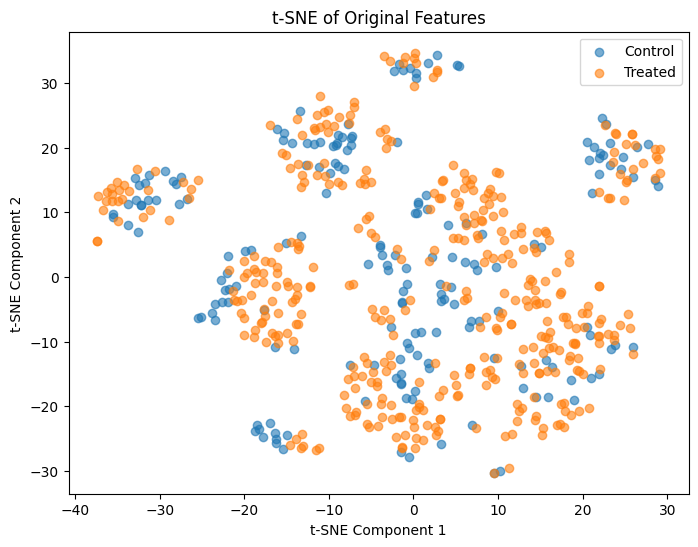

In [1159]:
data = df_train.copy()

data[input_columns] = scaler.transform(data[input_columns])
features = torch.tensor(data[input_columns].values, dtype=torch.float32)
treatment = torch.tensor(data['T'].values, dtype=torch.int64)
outcomes = torch.tensor(data['Y'].values, dtype=torch.float32)

# Perform t-SNE on original features
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features.numpy())  # Convert to numpy for t-SNE

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[treatment == 0, 0], tsne_results[treatment == 0, 1], label='Control', alpha=0.6)
plt.scatter(tsne_results[treatment == 1, 0], tsne_results[treatment == 1, 1], label='Treated', alpha=0.6)
plt.title('t-SNE of Original Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


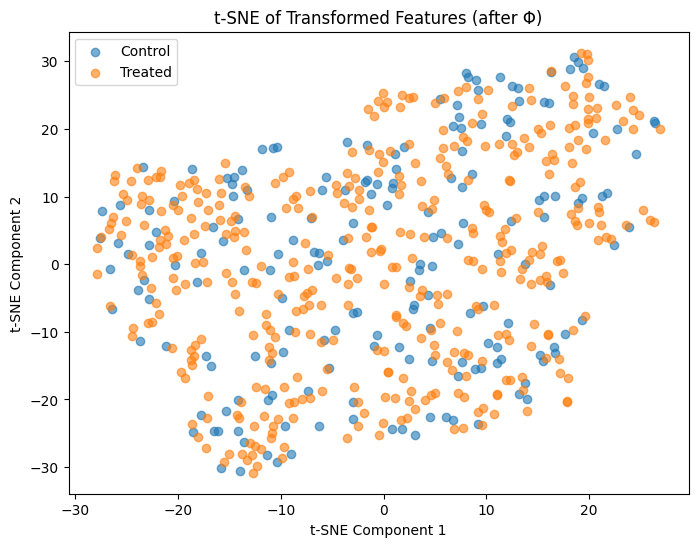

In [1160]:
data = df_train.copy()

data[input_columns] = scaler.transform(data[input_columns])
features = torch.tensor(data[input_columns].values, dtype=torch.float32)
treatment = torch.tensor(data['T'].values, dtype=torch.int64)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    transformed_features, _ = model((features, treatment))

# Perform t-SNE on transformed features
tsne = TSNE(n_components=2, random_state=42)
tsne_results_transformed = tsne.fit_transform(transformed_features.numpy())  # Convert to numpy for t-SNE

# Plot the t-SNE results for the transformed features
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_transformed[treatment == 0, 0], tsne_results_transformed[treatment == 0, 1], label='Control', alpha=0.6)
plt.scatter(tsne_results_transformed[treatment == 1, 0], tsne_results_transformed[treatment == 1, 1], label='Treated', alpha=0.6)
plt.title('t-SNE of Transformed Features (after Φ)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
